In [1]:
# import packages and libraries
import pandas as pd
import lightgbm
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import tools
import uuid
import os
init_notebook_mode(connected=True)
from sklearn.neighbors import KNeighborsRegressor
from modAL.models import ActiveLearner
import random
import sys
from random import randint
import pickle
from datetime import datetime
from modAL.models import ActiveLearner
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF
import matplotlib.pyplot as plt

from modAL.models import ActiveLearner
from modAL.models import CommitteeRegressor
from modAL.disagreement import max_std_sampling
from pathlib import Path

In [2]:
def rmse(true_values, predicted_values):
    n = len(true_values)
    residuals = 0
    for i in range(n):
        residuals += (true_values[i] - predicted_values[i]) ** 2.
    return np.sqrt(residuals / n)

In [3]:
#ensure repetabillity
seed = random.randrange(sys.maxsize)
random.seed(123456)
seed_list = []
for i in range(35):
    seed_list.append(randint(0, 4292967297))
#seed_list

In [4]:
input_file = '../../01_Data/pumadyn_8nm_ML.txt'
file_object = open(input_file, 'rb')
str_mdl = file_object.read()
model = pickle.loads(str_mdl)

[23:56:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [5]:
#validate on the random predictions from this range
actual_lows = {'theta1': -1.8, 'theta2': -1.8, 'theta3': -1.8, 'thetad1': -1.8, 'thetad2': -1.8, 'thetad3': -1.8,
              'tau1':-0.5, 'tau2':-0.5}
actual_highs = {'theta1': 1.8, 'theta2': 1.8, 'theta3': 1.8, 'thetad1': 1.8, 'thetad2': 1.8, 'thetad3': 1.8,
               'tau1':0.5, 'tau2':0.5} 
variables_ = ['theta1', 'theta2', 'theta3', 'thetad1', 'thetad2', 'thetad3', 'tau1', 'tau2', 'thetadd3']
samples_ = 10000

def random_generator(samples_, actual_lows, actual_highs, variables_, model):
    df_doe = pd.DataFrame(columns=variables_[:-1])
    for var in variables_[:-1]:
        df_doe[var] = np.random.uniform(actual_lows[var], actual_highs[var],
                                        samples_).round(3)
    df_doe[variables_[-1]] = model.predict(df_doe).round(2)
    return df_doe

def latin_hypercube_generator(samples_, actual_lows, actual_highs, variables, model):
    # actual_lows = {'AT': [2], 'V': [30], 'AP': [993], 'RH': [30]}  # , 'PE':[425]}
    # actual_highs = {'AT': [35], 'V': [80], 'AP': [1033], 'RH': [100]}  # , 'PE':[495]}
    # variables = ['AT', 'V', 'AP', 'RH', 'PE']
    # samples_ = 100000
    # np.random.seed(5234)
    df_doe = pd.DataFrame(lhs(len(variables) - 1, samples=samples_, criterion='maximin'))
    df_doe.columns = variables[:-1]
    for col in df_doe.columns:
        df_doe[col] = [actual_lows[col]] * df_doe.shape[0] + df_doe[col] * (actual_highs[col] - actual_lows[col])
        df_doe[col] = df_doe[col].apply(lambda x: round(x, 3))
    # df_doe = df_doe.reset_index()
    df_doe.columns = variables[:-1]
    df_doe[variables[-1]] = model.predict(df_doe).round(3)
    return df_doe

def normalize(input_array):
    mean = np.mean(input_array, axis=0)
    std = np.std(input_array, axis=0)

    # scikit-learn measure to handle zeros in scale: def _handle_zeros_in_scale(scale, copy=True)
    # https://github.com/scikit-learn/scikit-learn/blob/7389dbac82d362f296dc2746f10e43ffa1615660/sklearn/preprocessing/data.py#L70
    # if np.isscalar(std):
    #     if std == .0:
    #         std = 1.
    # elif isinstance(std, np.ndarray):
    #     std = std.copy()
    #     std[std == 0.0] = 1.0
    min = np.min(input_array, axis=0)
    max = np.max(input_array, axis=0)
    data_norm = (max - input_array) / (max - min)
    #data_norm = (input_array - mean) / std
    return min, max, data_norm

Validate

In [6]:
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
import lightgbm
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from pyDOE import lhs


cv_folds = 30
seedSize = 50
batchSize_mcs = 5
batchSize_lhc = 5
batchSize_qbc = 1
batchSize_gpr_al = 1
size_train_set = 200

committee_predictor = False

trainingSetSizes_mcs = np.arange(seedSize, size_train_set+1, batchSize_mcs)
trainingSetSizes_lhc = np.arange(seedSize, size_train_set+1, batchSize_lhc)
# trainingSetSizes_qbc = np.arange(seedSize, size_train_set+1, batchSize_qbc)
# trainingSetSizes_gpr_al = np.arange(seedSize, size_train_set+1, batchSize_gpr_al)
pth = str(Path().cwd().parents[1] / Path('01_Data') / Path('lhc_designs')) + str(Path("/"))

In [7]:
#validation set
# size_test_set = 5000
reference_regr = model
# np.random.seed(83746293)
# test_data = latin_hypercube_generator(size_test_set, actual_lows, actual_highs, variables_, reference_regr)
# test_data = np.array(test_data)
test_data = np.load(pth + 'lhc_test_pumadyn-8_sz_1000_randseed_83746293.npy')
size_test_set = test_data.shape[0]

# mcs_extension

In [8]:
#count_mcs = 0

In [9]:
numCommitteeMembers = 3

In [10]:
#count_mcs = 1
results_random = []
for cv in range(cv_folds):
    startTime = datetime.now()
    print('val {}'.format(cv))
    # for trainSize in trainingSetSizes_mcs:
    #for trainSize in range(seedSize, size_train_set+1):
    for trainSize in trainingSetSizes_mcs:
        # rr_params_v1 = {
        #     'alpha': 5, 'max_iter': 4, 'normalize': False, 'solver': 'lsqr', 'tol': 0.003}
        # predictor = Ridge(**rr_params_v1)

        # mlp_params_v1 = {
        #     'solver': 'adam', 'hidden_layer_sizes': (60, 60), 'activation': 'relu', 'tol': 1e-5, 'max_iter': 3000}
        # predictor = MLPRegressor(**mlp_params_v1)


        # mlp_params_v2 = {
        #     'solver': 'adam', 'hidden_layer_sizes': (120, 120, 120), 'activation': 'tanh', 'tol': 1e-5, 'max_iter': 1000}
        # predictor = MLPRegressor(**mlp_params_v2)

        lgbmParams = {  # 'learning_rate': 0.1,
            'n_estimators': 100,
            'objective': 'regression',
            'n_jobs': 7,
            'random_state': seed_list[cv]
                }
        predictor = lightgbm.LGBMRegressor(**lgbmParams)
        pred_str = str(predictor)
        pred_key = pred_str[:pred_str.find('(')]

        #np.random.seed(int(np.sqrt(2 + 0.1) * 1000))
        np.random.seed(seed_list[cv])
        train_data = np.array(random_generator(trainSize, actual_lows, actual_highs, variables_, reference_regr))
        #mean_data, std_data, data_all_norm = normalize(np.concatenate((train_data, test_data), axis=0))
        min_data, max_data, data_all_norm = normalize(np.concatenate((train_data, test_data), axis=0))

        X_train = train_data[:, :-1]
        X_test = test_data[:, :-1]
        y_train = train_data[:, -1].reshape((-1, 1))
        y_test = test_data[:, -1].reshape((-1, 1))

        # NORMALIZED DATA
        X_train_norm = data_all_norm[:train_data.shape[0], :-1]
        y_train_norm = data_all_norm[:train_data.shape[0], -1].reshape((-1, 1))
        X_test_norm = data_all_norm[train_data.shape[0]:, :-1]
        y_test_norm = data_all_norm[train_data.shape[0]:, -1].reshape((-1, 1))


        if committee_predictor:
            learner_list = []
            for i in range(numCommitteeMembers):
                learner_list.append(ActiveLearner(estimator=predictor,
                                                  X_training=X_train_norm,
                                                  y_training=y_train_norm.ravel(),
                                                  bootstrap_init=True))
            committee = CommitteeRegressor(learner_list=learner_list, query_strategy=max_std_sampling)
            #  -------->  MODEL FITTING  <------------------
            committee.teach(X_train_norm, y_train_norm.ravel())
            #  -------->  PREDICTION  <------------------
            mcs_y_norm = committee.predict(X_test_norm)
        else:
            #  -------->  MODEL FITTING  <------------------
            predictor.fit(X_train_norm, y_train_norm.ravel())
            #  -------->  PREDICTION  <------------------
            mcs_y_norm = predictor.predict(X_test_norm)

        # -------->  DENORMALIZATION OF PREDICTED VALUES  <------------------
        #mcs_y = mcs_y_norm * std_data[-1].reshape((-1, 1)) + mean_data[-1].reshape((-1, 1))
        mcs_y = max_data[-1].reshape((-1, 1)) - mcs_y_norm * (max_data[-1].reshape((-1, 1)) - min_data[-1].reshape((-1, 1)))


        preds_mcs = np.ravel(mcs_y)
        targets_mcs = np.ravel(y_test)
        r2_val = r2_score(targets_mcs, preds_mcs)
        rmse_val = rmse(targets_mcs, preds_mcs)

        #print('train size mcs {}'.format(trainSize))
        #print(r2_score(targets_mcs, preds_mcs))
        
        results_random.append({'Model': pred_key, 'CV': cv, 'Training_Size': trainSize,
                       'RMSE': rmse_val, 'r2_val': r2_val})
    endTime = datetime.now()
    print('Total time fold {} trainSize {}: {} '.format(cv, trainSize, (endTime - startTime) / 60))
        
res_df_random = pd.DataFrame(results_random)

val 0
Total time fold 0 trainSize 200: 0:00:00.044203 
val 1
Total time fold 1 trainSize 200: 0:00:00.043235 
val 2
Total time fold 2 trainSize 200: 0:00:00.043783 
val 3
Total time fold 3 trainSize 200: 0:00:00.043760 
val 4
Total time fold 4 trainSize 200: 0:00:00.041511 
val 5
Total time fold 5 trainSize 200: 0:00:00.041173 
val 6
Total time fold 6 trainSize 200: 0:00:00.049519 
val 7
Total time fold 7 trainSize 200: 0:00:00.054787 
val 8
Total time fold 8 trainSize 200: 0:00:00.054774 
val 9
Total time fold 9 trainSize 200: 0:00:00.044339 
val 10
Total time fold 10 trainSize 200: 0:00:00.062458 
val 11
Total time fold 11 trainSize 200: 0:00:00.051942 
val 12
Total time fold 12 trainSize 200: 0:00:00.053494 
val 13
Total time fold 13 trainSize 200: 0:00:00.060502 
val 14
Total time fold 14 trainSize 200: 0:00:00.061838 
val 15
Total time fold 15 trainSize 200: 0:00:00.065675 
val 16
Total time fold 16 trainSize 200: 0:00:00.063828 
val 17
Total time fold 17 trainSize 200: 0:00:00.05

In [11]:
res_df_random[res_df_random.Training_Size==100]

,Model,CV,Training_Size,RMSE,r2_val
10,LGBMRegressor,0,100,2.646519,0.758047
41,LGBMRegressor,1,100,2.633426,0.760435
72,LGBMRegressor,2,100,2.676867,0.752466
103,LGBMRegressor,3,100,2.885059,0.712465
134,LGBMRegressor,4,100,2.929497,0.703539
165,LGBMRegressor,5,100,2.821226,0.725048
196,LGBMRegressor,6,100,2.991965,0.690761
227,LGBMRegressor,7,100,2.727289,0.743053
258,LGBMRegressor,8,100,2.910300,0.707412
289,LGBMRegressor,9,100,2.753147,0.738158


In [12]:
res_df_random[res_df_random.Training_Size==200]

,Model,CV,Training_Size,RMSE,r2_val
30,LGBMRegressor,0,200,1.442602,0.928109
61,LGBMRegressor,1,200,1.473953,0.924950
92,LGBMRegressor,2,200,1.661955,0.904584
123,LGBMRegressor,3,200,1.351880,0.936867
154,LGBMRegressor,4,200,1.605112,0.911000
185,LGBMRegressor,5,200,1.611314,0.910311
216,LGBMRegressor,6,200,1.618672,0.909490
247,LGBMRegressor,7,200,1.550409,0.916963
278,LGBMRegressor,8,200,1.568731,0.914988
309,LGBMRegressor,9,200,1.380594,0.934156


# lhc

In [13]:
#count_lhc = 0

In [14]:
results_lhc = []
for cv in range(cv_folds):
    startTime = datetime.now()
    print('seed {}'.format(cv))
    for trainSize in trainingSetSizes_lhc:
        np.random.seed(seed_list[cv])
        try:
            fname_t = 'lhc_train_pumadyn-8_sz_' + str(trainSize) + '_randseed_' + str(seed_list[cv]) + '.npy'
            fname_p = 'lhc_pool_pumadyn-8_sz_' + str(trainSize) + '_randseed_' + str(seed_list[cv]) + '.npy'
            train_data =  np.load(pth + fname_t)
            pool_data = np.load(pth + fname_p)
        except:
            print('lhc file not found')
            train_data = np.array(
                latin_hypercube_generator(trainSize, actual_lows, actual_highs, variables_, reference_regr))
            #print(train_data[0])
            pool_data = np.array(latin_hypercube_generator(size_train_set, actual_lows, actual_highs, variables_,
                                      reference_regr))
            fname_t = 'lhc_train_pumadyn-8_sz_' + str(trainSize) + '_randseed_' + str(seed_list[cv])
            fname_p = 'lhc_pool_pumadyn-8_sz_' + str(trainSize) + '_randseed_' + str(seed_list[cv])
            np.save(pth + fname_t, train_data)
            np.save(pth + fname_p, pool_data)
        
        lgbmParams = {  # 'learning_rate': 0.1,
            'n_estimators': 100,
            'objective': 'regression',
            'n_jobs': 7,
            'random_state': seed_list[cv]
            }
        predictor = lightgbm.LGBMRegressor(**lgbmParams)
        pred_str = str(predictor)
        pred_key = pred_str[:pred_str.find('(')]
        
        # --------> STANDARDIZATION OF DATA SETS (subtraction of the mean, division by standard deviation) <------------------
        min_data, max_data, data_all_norm = normalize(np.concatenate((train_data, pool_data, test_data), axis=0))

        X_train = train_data[:, :-1]
        X_pool = pool_data[:, :-1]
        y_train = train_data[:, -1].reshape((-1, 1))
        y_pool = pool_data[:, -1].reshape((-1, 1))
        X_test = test_data[:, :-1]
        y_test = test_data[:, -1]

        # NORMALIZED DATA
        X_train_norm = data_all_norm[:train_data.shape[0], :-1]
        y_train_norm = data_all_norm[:train_data.shape[0], -1].reshape((-1, 1))
        X_pool_norm = data_all_norm[train_data.shape[0]:train_data.shape[0] + pool_data.shape[0], :-1]
        y_pool_norm = data_all_norm[train_data.shape[0]:train_data.shape[0] + pool_data.shape[0], -1].reshape((-1, 1))
        X_test_norm = data_all_norm[train_data.shape[0] + pool_data.shape[0]:, :-1]
        y_test_norm = data_all_norm[train_data.shape[0] + pool_data.shape[0]:, -1].reshape((-1, 1))

        #print(X_train_norm[0])
        # rr_params_v1 = {
        #     'alpha': 5, 'max_iter': 4, 'normalize': False, 'solver': 'lsqr', 'tol': 0.003}
        # predictor = Ridge(**rr_params_v1)

        learner_list=[]
        for i in range(numCommitteeMembers):
            learner_list.append(ActiveLearner(estimator=predictor,
                                              # estimator=sklearn.base.clone(predictor),
                                              X_training=X_train_norm,
                                              y_training=y_train_norm.ravel(),
                                              bootstrap_init=True))
        committee = CommitteeRegressor(learner_list=learner_list, query_strategy=max_std_sampling)


        if committee_predictor:
            #  -------->  MODEL FITTING  <------------------
            committee.teach(X_train_norm, y_train_norm.ravel())
            #  -------->  PREDICTION  <------------------
            qbc_y_norm = committee.predict(X_test_norm)
        else:
            #  -------->  MODEL FITTING  <------------------
            predictor.fit(X_train_norm, y_train_norm.ravel())
            #  -------->  PREDICTION  <------------------
            qbc_y_norm = predictor.predict(X_test_norm)

        # -------->  DENORMALIZATION OF PREDICTED VALUES  <------------------
        #qbc_y = qbc_y_norm * std_data[-1].reshape((-1, 1)) + mean_data[-1].reshape((-1, 1))
        qbc_y = max_data[-1].reshape((-1, 1)) - qbc_y_norm * (
                    max_data[-1].reshape((-1, 1)) - min_data[-1].reshape((-1, 1)))


        # -------->  SAVING THE PREDICTED AND TARGET VALUES  <------------------
        preds_qbc = np.ravel(qbc_y)
        targets_qbc = np.ravel(y_test)

        #print(r2_score(targets_qbc, preds_qbc))
        r2_val = r2_score(targets_qbc, preds_qbc)
        rmse_val = rmse(targets_qbc, preds_qbc)

        results_lhc.append({'Model': pred_key, 'CV': cv, 'Training_Size': trainSize,
                       'RMSE': rmse_val, 'r2_val': r2_val})
    endTime = datetime.now()
    print('Total time fold {} trainSize {}: {} '.format(cv, trainSize, (endTime - startTime) / 60))
        
res_df_lhc = pd.DataFrame(results_lhc)

    # count_lhc+=1

seed 0
Total time fold 0 trainSize 200: 0:00:00.195334 
seed 1
Total time fold 1 trainSize 200: 0:00:00.199718 
seed 2
Total time fold 2 trainSize 200: 0:00:00.176143 
seed 3
Total time fold 3 trainSize 200: 0:00:00.179703 
seed 4
Total time fold 4 trainSize 200: 0:00:00.160823 
seed 5
Total time fold 5 trainSize 200: 0:00:00.162234 
seed 6
Total time fold 6 trainSize 200: 0:00:00.167842 
seed 7
Total time fold 7 trainSize 200: 0:00:00.173461 
seed 8
Total time fold 8 trainSize 200: 0:00:00.173950 
seed 9
Total time fold 9 trainSize 200: 0:00:00.154952 
seed 10
Total time fold 10 trainSize 200: 0:00:00.162563 
seed 11
Total time fold 11 trainSize 200: 0:00:00.167669 
seed 12
Total time fold 12 trainSize 200: 0:00:00.171087 
seed 13
Total time fold 13 trainSize 200: 0:00:00.174359 
seed 14
Total time fold 14 trainSize 200: 0:00:00.155741 
seed 15
Total time fold 15 trainSize 200: 0:00:00.158421 
seed 16
Total time fold 16 trainSize 200: 0:00:00.169166 
seed 17
Total time fold 17 trainSi

In [15]:
res_df_lhc[res_df_lhc.Training_Size==100]

,Model,CV,Training_Size,RMSE,r2_val
10,LGBMRegressor,0,100,2.577188,0.770558
41,LGBMRegressor,1,100,2.915760,0.706313
72,LGBMRegressor,2,100,2.746501,0.739420
103,LGBMRegressor,3,100,3.095971,0.668888
134,LGBMRegressor,4,100,2.698179,0.748509
165,LGBMRegressor,5,100,2.467158,0.789731
196,LGBMRegressor,6,100,2.917732,0.705916
227,LGBMRegressor,7,100,2.674670,0.752872
258,LGBMRegressor,8,100,2.491592,0.785546
289,LGBMRegressor,9,100,2.631247,0.760831


In [16]:
res_df_lhc[res_df_lhc.Training_Size==200]

,Model,CV,Training_Size,RMSE,r2_val
30,LGBMRegressor,0,200,1.429144,0.929444
61,LGBMRegressor,1,200,1.258665,0.945273
92,LGBMRegressor,2,200,1.633541,0.907819
123,LGBMRegressor,3,200,1.605323,0.910976
154,LGBMRegressor,4,200,1.495106,0.922781
185,LGBMRegressor,5,200,1.678570,0.902667
216,LGBMRegressor,6,200,1.671868,0.903443
247,LGBMRegressor,7,200,1.277307,0.943640
278,LGBMRegressor,8,200,1.423528,0.929998
309,LGBMRegressor,9,200,1.701217,0.900023


# AL with qbc

In [17]:
#count_qbc = 0

In [18]:
# cv_folds = 10

In [19]:
from sklearn.ensemble import RandomForestRegressor

In [20]:
count_qbc= 0
PoolSetSize = 260 #260#260 #400
batchSize = 3
seedSize = 50
n_queries = 50

numCommitteeMembers = 3

results_qbc_t = []
for cv in range(cv_folds):
    learner_list = []
    startTime = datetime.now()
    #est = [100, 120, 140]
    
    print('seed {}'.format(cv))
#     train_data = np.array(latin_hypercube_generator(seedSize, actual_lows, actual_highs, variables_, reference_regr))
#     pool_data = np.array(latin_hypercube_generator(PoolSetSize, actual_lows, actual_highs, variables_, reference_regr))
    try:
        fname_t = 'lhc_train_pumadyn-8_sz_' + str(seedSize) + '_randseed_' + str(seed_list[cv]) + '.npy'
        fname_p = 'lhc_pool_pumadyn-8_sz_' + str(PoolSetSize) + '_randseed_' + str(seed_list[cv]) + '.npy'
        train_data =  np.load(pth + fname_t)
        pool_data = np.load(pth + fname_p)
    except:
        print('lhc file not found')
        np.random.seed(seed_list[cv])
        train_data = np.array(
            latin_hypercube_generator(seedSize, actual_lows, actual_highs, variables_, reference_regr))
        #print(train_data[0])
        pool_data = np.array(latin_hypercube_generator(PoolSetSize, actual_lows, actual_highs, variables_,
                                  reference_regr))
        fname_t = 'lhc_train_pumadyn-8_sz_' + str(seedSize) + '_randseed_' + str(seed_list[cv])
        fname_p = 'lhc_pool_pumadyn-8_sz_' + str(PoolSetSize) + '_randseed_' + str(seed_list[cv])
        np.save(pth + fname_t, train_data)
        np.save(pth + fname_p, pool_data)
        
    #num_leaves = [6,11,16]
    #num_leaves = [6,8,10] # best 2
    num_leaves = [8,9,10] # best 1
    num_leaves = [6,14,19]
    for i in range(numCommitteeMembers):
        lgbmParams = {  # 'learning_rate': 0.1,
            #'n_estimators': 100, #est[i],
            'num_leaves': num_leaves[i],
            #'bagging_freq':1,
            'objective': 'regression',
            'n_jobs': 7,
            #'boosting_type': 'rf',
            #'subsample_freq': 1, 
            #'bagging_fraction': 0.8, 
            #'feature_fraction': 0.8,
            'random_state': i*100
            }
        predictor = lightgbm.LGBMRegressor(**lgbmParams)
        
#         predictor = RandomForestRegressor(max_depth=num_leaves[i], 
#                                           random_state=i*100, 
#                                           #n_estimators=100, 
#                                           n_jobs=7)
        learner_list.append(ActiveLearner(estimator=predictor,
                                          # estimator=sklearn.base.clone(predictor),
                                          X_training=X_train_norm,
                                          y_training=y_train_norm.ravel(),
                                          bootstrap_init=True))
    committee = CommitteeRegressor(learner_list=learner_list, query_strategy=max_std_sampling)
    np.random.seed(seed_list[cv])
    
    lgbmParams = {  # 'learning_rate': 0.1,
        #'n_estimators': 100,
        'num_leaves': 5,
        'objective': 'regression',
        'n_jobs': 7,
        #'random_state': i
        }
    predictor = lightgbm.LGBMRegressor(**lgbmParams)

    # --------> STANDARDIZATION OF DATA SETS (subtraction of the mean, division by standard deviation) <------------------
    min_data, max_data, data_all_norm = normalize(np.concatenate((train_data, pool_data, test_data), axis=0))
    X_train = train_data[:, :-1]
    X_pool = pool_data[:, :-1]
    y_train = train_data[:, -1].reshape((-1, 1))
    y_pool = pool_data[:, -1].reshape((-1, 1))
    X_test = test_data[:, :-1]
    y_test = test_data[:, -1]

    # NORMALIZED DATA
    X_train_norm = data_all_norm[:train_data.shape[0], :-1]
    y_train_norm = data_all_norm[:train_data.shape[0], -1].reshape((-1, 1))
    X_pool_norm = data_all_norm[train_data.shape[0]:train_data.shape[0] + pool_data.shape[0], :-1]
    y_pool_norm = data_all_norm[train_data.shape[0]:train_data.shape[0] + pool_data.shape[0], -1].reshape((-1, 1))
    X_test_norm = data_all_norm[train_data.shape[0] + pool_data.shape[0]:, :-1]
    y_test_norm = data_all_norm[train_data.shape[0] + pool_data.shape[0]:, -1].reshape((-1, 1))
    #print(X_train_norm[0])


    committee.fit(X_train_norm, y_train_norm.ravel())
     #  -------->  Initial Evaluation  <------------------
    if committee_predictor:
        #  -------->  PREDICTION  <------------------
        qbc_y_norm = committee.predict(X_test_norm)
    else:
        #  -------->  MODEL FITTING  <------------------
        predictor.fit(X_train_norm, y_train_norm.ravel())
        #  -------->  PREDICTION  <------------------
        qbc_y_norm = predictor.predict(X_test_norm)

    qbc_y = max_data[-1].reshape((-1, 1)) - qbc_y_norm * (max_data[-1].reshape((-1, 1)) - min_data[-1].reshape((-1, 1)))
    preds_qbc = np.ravel(qbc_y)
    targets_qbc = np.ravel(y_test)

    #print('QBC before, train size {}'.format(X_train_norm.shape[0]))
    #print(r2_score(targets_qbc, preds_qbc))



    for itter in range(n_queries+1):
        #print(itter)
        if committee_predictor:
            #  -------->  MODEL FITTING  <------------------
            committee.teach(X_train_norm, y_train_norm.ravel())
            #  -------->  PREDICTION  <------------------
            qbc_y_norm = committee.predict(X_test_norm)
        else:
            #committee.teach(X_train_norm, y_train_norm.ravel())
            #  -------->  MODEL FITTING  <------------------
            predictor.fit(X_train_norm, y_train_norm.ravel())
            #  -------->  PREDICTION  <------------------
            qbc_y_norm = predictor.predict(X_test_norm)

        # -------->  DENORMALIZATION OF PREDICTED VALUES  <------------------
        qbc_y = max_data[-1].reshape((-1, 1)) - qbc_y_norm * (max_data[-1].reshape((-1, 1)) - min_data[-1].reshape((-1, 1)))
        preds_qbc = np.ravel(qbc_y)
        targets_qbc = np.ravel(y_test)
        #print('qbc after, train size {}'.format(seedSize + num_itter*batchSize))

        r2_val = r2_score(targets_qbc, preds_qbc)
        #print('size {}, r2 {}'.format(X_train_norm.shape[0], r2_val))
        rmse_val = rmse(targets_qbc, preds_qbc)

        results_qbc_t.append({'Model': pred_key, 'CV': cv, 'Training_Size': X_train_norm.shape[0],
                       'RMSE': rmse_val, 'r2_val': r2_val})

        # -------->  Pick new point  <------------------
        query_idx, query_instance = committee.query(X=X_pool_norm, n_instances=batchSize, random_tie_break=True)
        X_train = np.append(X_train, X_pool[query_idx], axis=0)
        y_train = np.append(y_train, y_pool[query_idx], axis=0)
        X_train_norm = np.append(X_train_norm, X_pool_norm[query_idx], axis=0)
        y_train_norm = np.append(y_train_norm, y_pool_norm[query_idx], axis=0)
        committee.teach(X_pool_norm[query_idx],
                        y_pool_norm.ravel()[query_idx])  # train committee on newly added data
        X_pool = np.delete(X_pool, query_idx, axis=0)
        y_pool = np.delete(y_pool, query_idx, axis=0)
        X_pool_norm = np.delete(X_pool_norm, query_idx, axis=0)
        y_pool_norm = np.delete(y_pool_norm, query_idx, axis=0)
        # print(X_pool_norm.shape)
    endTime = datetime.now()
    print('Total time fold {} trainSize {}: {} '.format(cv, X_train_norm.shape[0], (endTime - startTime) / 60))
res_df_qbc = pd.DataFrame(results_qbc_t)
count_qbc+=1

seed 0
Total time fold 0 trainSize 203: 0:00:00.176592 
seed 1
Total time fold 1 trainSize 203: 0:00:00.185250 
seed 2
Total time fold 2 trainSize 203: 0:00:00.200647 
seed 3
Total time fold 3 trainSize 203: 0:00:00.187195 
seed 4
Total time fold 4 trainSize 203: 0:00:00.182811 
seed 5
Total time fold 5 trainSize 203: 0:00:00.191292 
seed 6
Total time fold 6 trainSize 203: 0:00:00.177202 
seed 7
Total time fold 7 trainSize 203: 0:00:00.185075 
seed 8
Total time fold 8 trainSize 203: 0:00:00.187271 
seed 9
Total time fold 9 trainSize 203: 0:00:00.194775 
seed 10
Total time fold 10 trainSize 203: 0:00:00.200952 
seed 11
Total time fold 11 trainSize 203: 0:00:00.181080 
seed 12
Total time fold 12 trainSize 203: 0:00:00.195549 
seed 13
Total time fold 13 trainSize 203: 0:00:00.201129 
seed 14
Total time fold 14 trainSize 203: 0:00:00.174315 
seed 15
Total time fold 15 trainSize 203: 0:00:00.187908 
seed 16
Total time fold 16 trainSize 203: 0:00:00.196405 
seed 17
Total time fold 17 trainSi

In [21]:
res_df_qbc[res_df_qbc.Training_Size==50]

,Model,CV,Training_Size,RMSE,r2_val
0,LGBMRegressor,0,50,3.384242,0.604357
51,LGBMRegressor,1,50,3.405248,0.599430
102,LGBMRegressor,2,50,3.538268,0.567524
153,LGBMRegressor,3,50,3.823468,0.494995
204,LGBMRegressor,4,50,3.590784,0.554590
255,LGBMRegressor,5,50,3.402768,0.600013
306,LGBMRegressor,6,50,3.720514,0.521825
357,LGBMRegressor,7,50,3.828856,0.493570
408,LGBMRegressor,8,50,3.517550,0.572573
459,LGBMRegressor,9,50,3.527138,0.570240


In [22]:
res_df_qbc[res_df_qbc.Training_Size==200]

,Model,CV,Training_Size,RMSE,r2_val
50,LGBMRegressor,0,200,1.669840,0.903677
101,LGBMRegressor,1,200,1.516685,0.920536
152,LGBMRegressor,2,200,1.616231,0.909762
203,LGBMRegressor,3,200,1.779629,0.890594
254,LGBMRegressor,4,200,1.614074,0.910003
305,LGBMRegressor,5,200,1.923731,0.872159
356,LGBMRegressor,6,200,1.689948,0.901343
407,LGBMRegressor,7,200,1.509097,0.921329
458,LGBMRegressor,8,200,1.524740,0.919689
509,LGBMRegressor,9,200,1.591183,0.912538


# AL with Gaussian Process Regressor

In [23]:
# count_gpr = 0

In [24]:
import warnings
warnings.filterwarnings("ignore")

def GP_regression_std(regressor, X):
    _, std = regressor.predict(X, return_std=True)
    query_idx = np.argmax(std)
    return query_idx, X[query_idx]

numCommitteeMembers = 3
PoolSetSize = 200
seedSize = 50

results_al_gpr = []
for cv in range(cv_folds):
    startTime = datetime.now()
    print('seed {}'.format(cv))
    for i in range(numCommitteeMembers):
        lgbmParams = {  # 'learning_rate': 0.1,
            'n_estimators': 100,
            'objective': 'regression',
            'n_jobs': 7,
            'random_state': i
            }
        predictor = lightgbm.LGBMRegressor(**lgbmParams)
#         learner_list.append(ActiveLearner(estimator=predictor,
#                                           # estimator=sklearn.base.clone(predictor),
#                                           X_training=X_train_norm,
#                                           y_training=y_train_norm.ravel(),
#                                           bootstrap_init=True))
#     committee = CommitteeRegressor(learner_list=learner_list, query_strategy=max_std_sampling)
    
    np.random.seed(seed_list[cv])
    
    try:
        fname_t = 'lhc_train_pumadyn-8_sz_' + str(seedSize) + '_randseed_' + str(seed_list[cv]) + '.npy'
        fname_p = 'lhc_pool_pumadyn-8_sz_' + str(PoolSetSize) + '_randseed_' + str(seed_list[cv]) + '.npy'
        train_data =  np.load(pth + fname_t)
        pool_data = np.load(pth + fname_p)
    except:
        print('lhc file not found')
        np.random.seed(seed_list[cv])
        train_data = np.array(latin_hypercube_generator(seedSize, actual_lows, actual_highs, variables_, reference_regr))
        pool_data = np.array(latin_hypercube_generator(PoolSetSize, actual_lows, actual_highs, variables_,
                                  reference_regr))
        fname_t = 'lhc_train_pumadyn-8_sz_' + str(seedSize) + '_randseed_' + str(seed_list[cv])
        fname_p = 'lhc_pool_pumadyn-8_sz_' + str(PoolSetSize) + '_randseed_' + str(seed_list[cv])
        np.save(pth + fname_t, train_data)
        np.save(pth + fname_p, pool_data)
    
#     train_data = np.array(latin_hypercube_generator(seedSize, actual_lows, actual_highs, variables_, reference_regr))
#     pool_data = np.array(latin_hypercube_generator(PoolSetSize, actual_lows, actual_highs, variables_, reference_regr))
    
    # --------> STANDARDIZATION OF DATA SETS (subtraction of the mean, division by standard deviation) <------------------
    min_data, max_data, data_all_norm = normalize(np.concatenate((train_data, pool_data, test_data), axis=0))
    X_train = train_data[:, :-1]
    X_pool = pool_data[:, :-1]
    y_train = train_data[:, -1].reshape((-1, 1))
    y_pool = pool_data[:, -1].reshape((-1, 1))
    X_test = test_data[:, :-1]
    y_test = test_data[:, -1]

    # NORMALIZED DATA
    X_train_norm = data_all_norm[:train_data.shape[0], :-1]
    y_train_norm = data_all_norm[:train_data.shape[0], -1].reshape((-1, 1))
    X_pool_norm = data_all_norm[train_data.shape[0]:train_data.shape[0] + pool_data.shape[0], :-1]
    y_pool_norm = data_all_norm[train_data.shape[0]:train_data.shape[0] + pool_data.shape[0], -1].reshape((-1, 1))
    X_test_norm = data_all_norm[train_data.shape[0] + pool_data.shape[0]:, :-1]
    y_test_norm = data_all_norm[train_data.shape[0] + pool_data.shape[0]:, -1].reshape((-1, 1))
    
    # Create GPR as an active learner
    kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) \
         + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))
    committee = ActiveLearner(
        estimator=GaussianProcessRegressor(kernel=kernel),
        query_strategy=GP_regression_std,
        X_training=X_train_norm, y_training=y_train_norm.ravel()
        )
    
    committee.fit(X_train_norm, y_train_norm.ravel())
    for itter in range(size_train_set-seedSize+1):
        if committee_predictor:
            #  -------->  PREDICTION  <------------------
            al_gpr_y_norm = committee.predict(X_test_norm)
        else:
            #  -------->  MODEL FITTING  <------------------
            predictor.fit(X_train_norm, y_train_norm.ravel())
            #  -------->  PREDICTION  <------------------
            al_gpr_y_norm = predictor.predict(X_test_norm)

        # -------->  DENORMALIZATION OF PREDICTED VALUES  <------------------
        al_gpr_y = max_data[-1].reshape((-1, 1)) - al_gpr_y_norm * (max_data[-1].reshape((-1, 1)) - min_data[-1].reshape((-1, 1)))
        preds_al_gpr = np.ravel(al_gpr_y)
        targets_al_gpr = np.ravel(y_test)
        
        r2_val = r2_score(targets_al_gpr, preds_al_gpr)
        rmse_val = rmse(targets_al_gpr, preds_al_gpr)

        results_al_gpr.append({'Model': pred_key, 'CV': cv, 'Training_Size': X_train_norm.shape[0],
                       'RMSE': rmse_val, 'r2_val': r2_val})

        # -------->  Pick new point  <------------------
        query_idx, query_instance = committee.query(X=X_pool_norm)
        X_train_norm = np.append(X_train_norm, X_pool_norm[query_idx].reshape(1,-1), axis=0)
        y_train_norm = np.append(y_train_norm, y_pool_norm[query_idx].reshape(1,-1), axis=0)
        committee.teach(X_pool_norm[[query_idx]], y_pool_norm[[query_idx]].ravel())  # train committee on newly added data
        X_pool = np.delete(X_pool, query_idx, axis=0)
        y_pool = np.delete(y_pool, query_idx, axis=0)
        X_pool_norm = np.delete(X_pool_norm, query_idx, axis=0)
        y_pool_norm = np.delete(y_pool_norm, query_idx, axis=0)

    endTime = datetime.now()
    print('Total time fold {} trainSize {}: {} '.format(cv, X_train_norm.shape[0], (endTime - startTime) / 60))
        
res_df_al_gpr = pd.DataFrame(results_al_gpr)

seed 0
Total time fold 0 trainSize 201: 0:00:00.280443 
seed 1
Total time fold 1 trainSize 201: 0:00:00.261582 
seed 2
Total time fold 2 trainSize 201: 0:00:00.273178 
seed 3
Total time fold 3 trainSize 201: 0:00:00.275770 
seed 4
Total time fold 4 trainSize 201: 0:00:00.259754 
seed 5
Total time fold 5 trainSize 201: 0:00:00.282869 
seed 6
Total time fold 6 trainSize 201: 0:00:00.266893 
seed 7
Total time fold 7 trainSize 201: 0:00:00.270736 
seed 8
Total time fold 8 trainSize 201: 0:00:00.273034 
seed 9
Total time fold 9 trainSize 201: 0:00:00.262390 
seed 10
Total time fold 10 trainSize 201: 0:00:00.267994 
seed 11
Total time fold 11 trainSize 201: 0:00:00.279507 
seed 12
Total time fold 12 trainSize 201: 0:00:00.272923 
seed 13
Total time fold 13 trainSize 201: 0:00:00.273627 
seed 14
Total time fold 14 trainSize 201: 0:00:00.274408 
seed 15
Total time fold 15 trainSize 201: 0:00:00.274861 
seed 16
Total time fold 16 trainSize 201: 0:00:00.279213 
seed 17
Total time fold 17 trainSi

In [25]:
res_df_al_gpr[res_df_al_gpr.Training_Size==50]

,Model,CV,Training_Size,RMSE,r2_val
0,LGBMRegressor,0,50,3.384242,0.604357
151,LGBMRegressor,1,50,3.405248,0.599430
302,LGBMRegressor,2,50,3.538268,0.567524
453,LGBMRegressor,3,50,3.823468,0.494995
604,LGBMRegressor,4,50,3.590784,0.554590
755,LGBMRegressor,5,50,3.402768,0.600013
906,LGBMRegressor,6,50,3.720514,0.521825
1057,LGBMRegressor,7,50,3.828856,0.493570
1208,LGBMRegressor,8,50,3.517550,0.572573
1359,LGBMRegressor,9,50,3.527138,0.570240


In [26]:
res_df_al_gpr[res_df_al_gpr.Training_Size==200]

,Model,CV,Training_Size,RMSE,r2_val
150,LGBMRegressor,0,200,1.444813,0.927888
301,LGBMRegressor,1,200,1.398179,0.932468
452,LGBMRegressor,2,200,1.518513,0.920344
603,LGBMRegressor,3,200,1.369773,0.935185
754,LGBMRegressor,4,200,1.237193,0.947124
905,LGBMRegressor,5,200,1.230633,0.947684
1056,LGBMRegressor,6,200,1.368610,0.935295
1207,LGBMRegressor,7,200,1.434311,0.928933
1358,LGBMRegressor,8,200,1.461673,0.926196
1509,LGBMRegressor,9,200,1.270950,0.944200


# Visualize

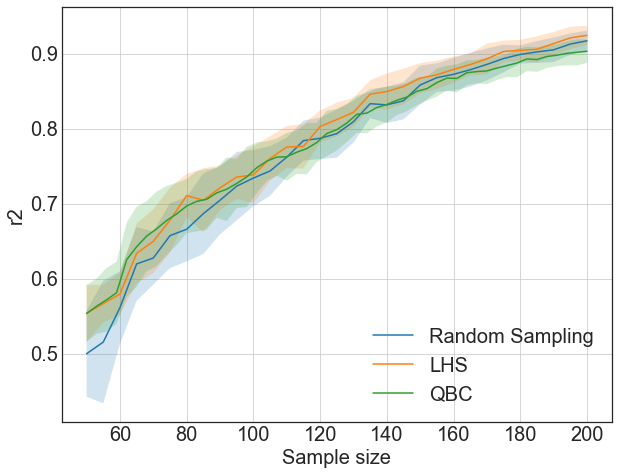

In [31]:
font = {'family' : 'arial',
        'weight' : 'normal',
        'size'   : 20}

plt.rc('font', **font)


def plot_learning_curve_r2(df_target, label, title=''):
    df_target_filt = df_target[df_target.Model == mdl]
    df_target_mean = df_target_filt.groupby(['Model', 'Training_Size']).r2_val.mean().reset_index()
    df_target_std = df_target_filt.groupby(['Model', 'Training_Size']).r2_val.std().reset_index()
    plt.plot(df_target_mean.Training_Size, df_target_mean.r2_val, label=label, linestyle='-')
    plt.fill_between(df_target_mean.Training_Size, df_target_mean.r2_val - df_target_std.r2_val,
                     df_target_mean.r2_val + df_target_std.r2_val, alpha=0.2)
    ax.set_xlabel('Sample size')
    ax.set_ylabel('r2')
    ax.legend(loc='best')
    #plt.title(title)
    plt.grid()
    #plt.figure(figsize=(6,6))
    return plt

metadata = pred_key + '_SzTr_' + str(seedSize) + '+' + str(size_train_set) + '_SzTest_' + str(
    size_test_set) + '_CV_' + str(cv_folds) + '_BatchSz_' + str(batchSize) + '_CommitteePred_' + str(
    committee_predictor) + '_CommitteeSize_' + str(numCommitteeMembers) + '_PoolSetSize_' + str(PoolSetSize)

# res_df_qbc_filt = res_df_qbc[res_df_qbc['Training_Size'].isin(res_df_lhc.Training_Size.unique())]
# res_df_al_gpr_filt = res_df_al_gpr[res_df_al_gpr['Training_Size'].isin(res_df_lhc.Training_Size.unique())]

for mdl in res_df_random.Model.unique():
    with plt.style.context('seaborn-white'):
        fig = plt.figure(figsize=(9, 7))
        ax = fig.add_subplot(111)
        plot_learning_curve_r2(res_df_random, 'Random Sampling', metadata)
        plot_learning_curve_r2(res_df_lhc, 'LHS', metadata)
        plot_learning_curve_r2(res_df_qbc, 'QBC', metadata)
        #plot_learning_curve_r2(res_df_al_gpr, 'al_gpr', metadata)
        plt.legend(loc='lower right')
        plt.tight_layout()
        fig.savefig('puma_8_nm_al_lhc_mcs_results_' + mdl + '.png', dpi=300)
        plt.show()

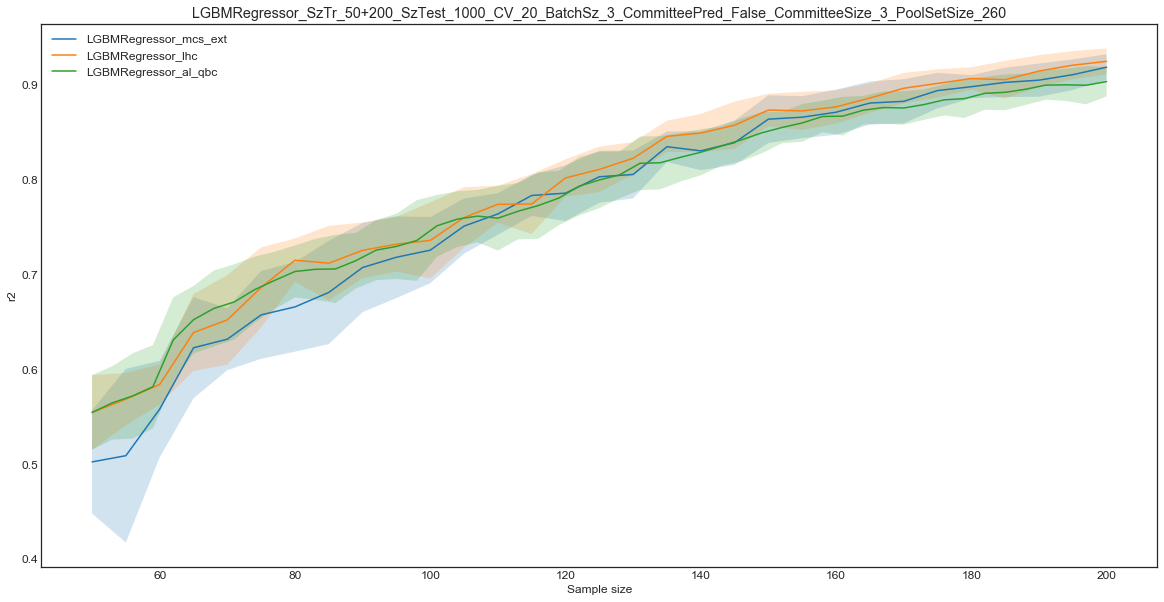

In [49]:
def plot_learning_curve_r2(df_target, label, title=''):
    df_target_filt = df_target[df_target.Model == mdl]
    df_target_mean = df_target_filt.groupby(['Model', 'Training_Size']).r2_val.mean().reset_index()
    df_target_std = df_target_filt.groupby(['Model', 'Training_Size']).r2_val.std().reset_index()
    plt.plot(df_target_mean.Training_Size, df_target_mean.r2_val, label=mdl + '_' + label, linestyle='-')
    plt.fill_between(df_target_mean.Training_Size, df_target_mean.r2_val - df_target_std.r2_val,
                     df_target_mean.r2_val + df_target_std.r2_val, alpha=0.2)
    ax.set_xlabel('Sample size')
    ax.set_ylabel('r2')
    ax.legend(loc='best')
    plt.title(title)
    return plt

metadata = pred_key + '_SzTr_' + str(seedSize) + '+' + str(size_train_set) + '_SzTest_' + str(
    size_test_set) + '_CV_' + str(cv_folds) + '_BatchSz_' + str(batchSize) + '_CommitteePred_' + str(
    committee_predictor) + '_CommitteeSize_' + str(numCommitteeMembers) + '_PoolSetSize_' + str(PoolSetSize)

# res_df_qbc_filt = res_df_qbc[res_df_qbc['Training_Size'].isin(res_df_lhc.Training_Size.unique())]
# res_df_al_gpr_filt = res_df_al_gpr[res_df_al_gpr['Training_Size'].isin(res_df_lhc.Training_Size.unique())]

for mdl in res_df_random.Model.unique():
    with plt.style.context('seaborn-white'):
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111)
        plot_learning_curve_r2(res_df_random, 'mcs_ext', metadata)
        plot_learning_curve_r2(res_df_lhc, 'lhc', metadata)
        plot_learning_curve_r2(res_df_qbc, 'al_qbc', metadata)
        #plot_learning_curve_r2(res_df_al_gpr, 'al_gpr', metadata)
        # fig.savefig('al_lhc_mcs_results' + mdl + '.png', dpi=300)
        plt.show()

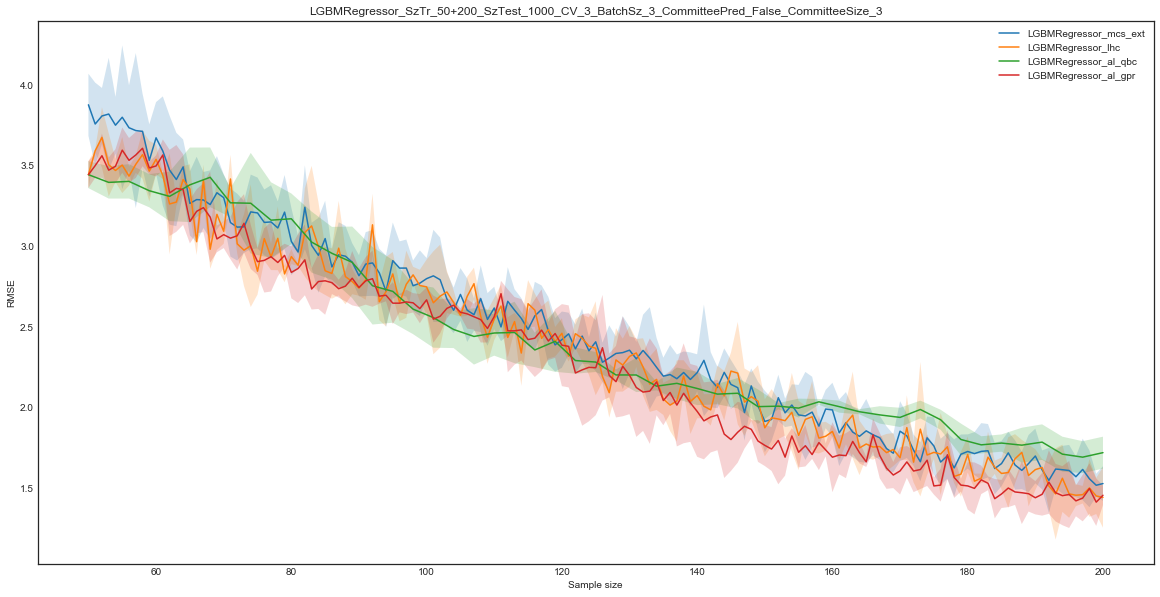

In [99]:
def plot_learning_curve_rmse(df_target, label, title=''):
    df_target_filt = df_target[df_target.Model == mdl]
    df_target_mean = df_target_filt.groupby(['Model', 'Training_Size']).RMSE.mean().reset_index()
    df_target_std = df_target_filt.groupby(['Model', 'Training_Size']).RMSE.std().reset_index()
    plt.plot(df_target_mean.Training_Size, df_target_mean.RMSE, label=mdl + '_' + label, linestyle='-')
    plt.fill_between(df_target_mean.Training_Size, df_target_mean.RMSE - df_target_std.RMSE,
                     df_target_mean.RMSE + df_target_std.RMSE, alpha=0.2)
    ax.set_xlabel('Sample size')
    ax.set_ylabel('RMSE')
    ax.legend(loc='best')
    plt.title(title)
    return plt

metadata = pred_key + '_SzTr_' + str(seedSize) + '+' + str(size_train_set) + '_SzTest_' + str(
    size_test_set) + '_CV_' + str(cv_folds) + '_BatchSz_' + str(batchSize) + '_CommitteePred_' + str(
    committee_predictor) + '_CommitteeSize_' + str(numCommitteeMembers)

for mdl in res_df_random.Model.unique():
    with plt.style.context('seaborn-white'):
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111)
        plot_learning_curve_rmse(res_df_random, 'mcs_ext', metadata)
        plot_learning_curve_rmse(res_df_lhc, 'lhc', metadata)
        plot_learning_curve_rmse(res_df_qbc, 'al_qbc', metadata)
        plot_learning_curve_rmse(res_df_al_gpr, 'al_gpr', metadata)
        # fig.savefig('al_lhc_mcs_results' + mdl + '.png', dpi=300)
        plt.show()

# Old GPR

In [69]:
count_gpr = 0

In [70]:
PoolSetSize = 251
seedSize = 150
n_queries = 250

lgbmParams = {  # 'learning_rate': 0.1,
    'n_estimators': 100,
    'objective': 'regression',
    'n_jobs': 1,
    'random_state': seed_list[count_gpr]
    }

predictor = lightgbm.LGBMRegressor(**lgbmParams)
print('seed {}'.format(count_gpr))
#print('seed {}'.format(count_gpr))
np.random.seed(seed_list[count_gpr])
train_data = np.array(latin_hypercube_generator(seedSize, actual_lows, actual_highs, variables_, reference_regr))
pool_data = np.array(latin_hypercube_generator(PoolSetSize, actual_lows, actual_highs, variables_, reference_regr))
# --------> STANDARDIZATION OF DATA SETS (subtraction of the mean, division by standard deviation) <------------------
min_data, max_data, data_all_norm = normalize(np.concatenate((train_data, pool_data, test_data), axis=0))
X_train = train_data[:, :-1]
X_pool = pool_data[:, :-1]
y_train = train_data[:, -1].reshape((-1, 1))
y_pool = pool_data[:, -1].reshape((-1, 1))
X_test = test_data[:, :-1]
y_test = test_data[:, -1]

# NORMALIZED DATA
X_train_norm = data_all_norm[:train_data.shape[0], :-1]
y_train_norm = data_all_norm[:train_data.shape[0], -1].reshape((-1, 1))
X_pool_norm = data_all_norm[train_data.shape[0]:train_data.shape[0] + pool_data.shape[0], :-1]
y_pool_norm = data_all_norm[train_data.shape[0]:train_data.shape[0] + pool_data.shape[0], -1].reshape((-1, 1))
X_test_norm = data_all_norm[train_data.shape[0] + pool_data.shape[0]:, :-1]
y_test_norm = data_all_norm[train_data.shape[0] + pool_data.shape[0]:, -1].reshape((-1, 1))

def GP_regression_std(regressor, X):
    _, std = regressor.predict(X, return_std=True)
    query_idx = np.argmax(std)
    return query_idx, X[query_idx]

from modAL.models import ActiveLearner
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF

#n_initial = 50
kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) \
         + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))

committee = ActiveLearner(
    estimator=GaussianProcessRegressor(kernel=kernel),
    query_strategy=GP_regression_std,
    X_training=X_train_norm, y_training=y_train_norm.ravel()
)
#committee.fit(X_train_norm, y_train_norm.ravel())
qbc_y_norm = committee.predict(X_test_norm)
qbc_y = max_data[-1].reshape((-1, 1)) - qbc_y_norm * (
            max_data[-1].reshape((-1, 1)) - min_data[-1].reshape((-1, 1)))

preds_qbc = np.ravel(qbc_y)
targets_qbc = np.ravel(y_test)
r2_score(targets_qbc, preds_qbc)



import warnings
warnings.filterwarnings("ignore")

#  -------->  MODEL FITTING  <------------------
predictor.fit(X_train_norm, y_train_norm.ravel())
#  -------->  PREDICTION  <------------------
qbc_y_norm = predictor.predict(X_test_norm)
# -------->  DENORMALIZATION OF PREDICTED VALUES  <------------------
qbc_y = max_data[-1].reshape((-1, 1)) - qbc_y_norm * (
            max_data[-1].reshape((-1, 1)) - min_data[-1].reshape((-1, 1)))
# -------->  Evaluation  <------------------
preds_qbc = np.ravel(qbc_y)
targets_qbc = np.ravel(y_test)
print('AL GPR before, train size {}'.format(X_train_norm.shape[0]))
#print(X_train_norm[0])
print(r2_score(targets_qbc, preds_qbc))
      
#np.random.seed(12345)
for idx in range(n_queries):
    query_idx, query_instance = committee.query(X_pool_norm)
    #print(X_pool_norm[0])
#     print(query_idx)
#     print(query_instance)
    
    #X_train = np.append(X_train, X_pool[query_idx].reshape(1,-1), axis=0)
    #y_train = np.append(y_train, y_pool[query_idx].reshape(1,-1), axis=0)
    X_train_norm = np.append(X_train_norm, X_pool_norm[query_idx].reshape(1,-1), axis=0)
    y_train_norm = np.append(y_train_norm, y_pool_norm[query_idx].reshape(1,-1), axis=0)
    
    committee.teach(X_pool_norm[[query_idx]], y_pool_norm[[query_idx]].ravel())
    
    X_pool = np.delete(X_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx, axis=0)
    X_pool_norm = np.delete(X_pool_norm, query_idx, axis=0)
    y_pool_norm = np.delete(y_pool_norm, query_idx, axis=0)
    
#  -------->  MODEL FITTING  <------------------
predictor.fit(X_train_norm, y_train_norm.ravel())
#  -------->  PREDICTION  <------------------
qbc_y_norm = predictor.predict(X_test_norm)
# -------->  DENORMALIZATION OF PREDICTED VALUES  <------------------
qbc_y = max_data[-1].reshape((-1, 1)) - qbc_y_norm * (
            max_data[-1].reshape((-1, 1)) - min_data[-1].reshape((-1, 1)))
# -------->  Evaluation  <------------------
preds_qbc = np.ravel(qbc_y)
targets_qbc = np.ravel(y_test)
print('AL GPR after, train size {}'.format(X_train_norm.shape[0]))
print(r2_score(targets_qbc, preds_qbc))
count_gpr += 1

seed 1
AL GPR before, train size 150
0.2847234742263258
AL GPR after, train size 400
0.9459554964591618


# Tune QBC

In [32]:
count_qbc= 0

In [23]:
count_qbc= 2
PoolSetSize = 260 #400
batchSize = 5
seedSize = 150
n_queries = 50

numCommitteeMembers = 3

results_qbc_t = []
learner_list = []
results_qbc_t = []

startTime = datetime.now()
for i in range(numCommitteeMembers):
    lgbmParams = {  # 'learning_rate': 0.1,
        'n_estimators': 100,
        'objective': 'regression',
        'n_jobs': 7,
        'random_state': i*100
        }
    predictor = lightgbm.LGBMRegressor(**lgbmParams)
    learner_list.append(ActiveLearner(estimator=predictor,
                                      # estimator=sklearn.base.clone(predictor),
                                      X_training=X_train_norm,
                                      y_training=y_train_norm.ravel(),
                                      bootstrap_init=True))
committee = CommitteeRegressor(learner_list=learner_list, query_strategy=max_std_sampling)
np.random.seed(seed_list[count_qbc])
print('seed {}'.format(count_qbc))
train_data = np.array(latin_hypercube_generator(seedSize, actual_lows, actual_highs, variables_, reference_regr))
#print(train_data[0])
#np.random.seed(seed_list[cv])
pool_data = np.array(latin_hypercube_generator(PoolSetSize, actual_lows, actual_highs, variables_, reference_regr))
#print(pool_data[0])
print('1')
# --------> STANDARDIZATION OF DATA SETS (subtraction of the mean, division by standard deviation) <------------------
min_data, max_data, data_all_norm = normalize(np.concatenate((train_data, pool_data, test_data), axis=0))
X_train = train_data[:, :-1]
X_pool = pool_data[:, :-1]
y_train = train_data[:, -1].reshape((-1, 1))
y_pool = pool_data[:, -1].reshape((-1, 1))
X_test = test_data[:, :-1]
y_test = test_data[:, -1]

# NORMALIZED DATA
X_train_norm = data_all_norm[:train_data.shape[0], :-1]
y_train_norm = data_all_norm[:train_data.shape[0], -1].reshape((-1, 1))
X_pool_norm = data_all_norm[train_data.shape[0]:train_data.shape[0] + pool_data.shape[0], :-1]
y_pool_norm = data_all_norm[train_data.shape[0]:train_data.shape[0] + pool_data.shape[0], -1].reshape((-1, 1))
X_test_norm = data_all_norm[train_data.shape[0] + pool_data.shape[0]:, :-1]
y_test_norm = data_all_norm[train_data.shape[0] + pool_data.shape[0]:, -1].reshape((-1, 1))
print('1')


committee.fit(X_train_norm, y_train_norm.ravel())
 #  -------->  Initial Evaluation  <------------------
if committee_predictor:
    #  -------->  PREDICTION  <------------------
    qbc_y_norm = committee.predict(X_test_norm)
else:
    #  -------->  MODEL FITTING  <------------------
    predictor.fit(X_train_norm, y_train_norm.ravel())
    #  -------->  PREDICTION  <------------------
    qbc_y_norm = predictor.predict(X_test_norm)
print('1')
qbc_y = max_data[-1].reshape((-1, 1)) - qbc_y_norm * (max_data[-1].reshape((-1, 1)) - min_data[-1].reshape((-1, 1)))
preds_qbc = np.ravel(qbc_y)
targets_qbc = np.ravel(y_test)

#print('QBC before, train size {}'.format(X_train_norm.shape[0]))
#print(r2_score(targets_qbc, preds_qbc))



for itter in range(n_queries+1):
    #print(itter)
    if committee_predictor:
        #  -------->  MODEL FITTING  <------------------
        committee.teach(X_train_norm, y_train_norm.ravel())
        #  -------->  PREDICTION  <------------------
        qbc_y_norm = committee.predict(X_test_norm)
    else:
        #committee.teach(X_train_norm, y_train_norm.ravel())
        #  -------->  MODEL FITTING  <------------------
        predictor.fit(X_train_norm, y_train_norm.ravel())
        #  -------->  PREDICTION  <------------------
        qbc_y_norm = predictor.predict(X_test_norm)

    # -------->  DENORMALIZATION OF PREDICTED VALUES  <------------------
    qbc_y = max_data[-1].reshape((-1, 1)) - qbc_y_norm * (max_data[-1].reshape((-1, 1)) - min_data[-1].reshape((-1, 1)))
    preds_qbc = np.ravel(qbc_y)
    targets_qbc = np.ravel(y_test)
    #print('qbc after, train size {}'.format(seedSize + num_itter*batchSize))

    r2_val = r2_score(targets_qbc, preds_qbc)
    print('size {}, r2 {}'.format(X_train_norm.shape[0], r2_val))
    rmse_val = rmse(targets_qbc, preds_qbc)

    results_qbc_t.append({'Model': pred_key, 'CV': cv, 'Training_Size': X_train_norm.shape[0],
                   'RMSE': rmse_val, 'r2_val': r2_val})

    # -------->  Pick new point  <------------------
    query_idx, query_instance = committee.query(X=X_pool_norm, n_instances=batchSize)
    X_train = np.append(X_train, X_pool[query_idx], axis=0)
    y_train = np.append(y_train, y_pool[query_idx], axis=0)
    X_train_norm = np.append(X_train_norm, X_pool_norm[query_idx], axis=0)
    y_train_norm = np.append(y_train_norm, y_pool_norm[query_idx], axis=0)
    committee.teach(X_pool_norm[query_idx],
                    y_pool_norm.ravel()[query_idx])  # train committee on newly added data
    X_pool = np.delete(X_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx, axis=0)
    X_pool_norm = np.delete(X_pool_norm, query_idx, axis=0)
    y_pool_norm = np.delete(y_pool_norm, query_idx, axis=0)
    # print(X_pool_norm.shape)

endTime = datetime.now()
print('Total time fold {} trainSize {}: {} '.format(cv, X_train_norm.shape[0], (endTime - startTime) / 60))
res_df_qbc = pd.DataFrame(results_qbc_t)
count_qbc+=1

seed 2
1
1
1
size 150, r2 0.35445386655170497
size 155, r2 0.340873770610048
size 160, r2 0.38841403268328645
size 165, r2 0.3864077306869165
size 170, r2 0.4390538958775101
size 175, r2 0.5588433343854644
size 180, r2 0.5095936092298412
size 185, r2 0.6942965612891441
size 190, r2 0.7167600911786798
size 195, r2 0.7644677264409534
size 200, r2 0.6572942766775371
size 205, r2 0.7828379240048782
size 210, r2 0.7918665687182542
size 215, r2 0.7886589649560223
size 220, r2 0.8171275667250548
size 225, r2 0.8138557154221708
size 230, r2 0.8127679410582134
size 235, r2 0.8338991422011794
size 240, r2 0.8369270601832728
size 245, r2 0.8487277747863331
size 250, r2 0.8823386245033785
size 255, r2 0.8837254795285228
size 260, r2 0.9076315463111355
size 265, r2 0.8849960580669709
size 270, r2 0.9055399258336457
size 275, r2 0.8920317275598293
size 280, r2 0.8733776113192481
size 285, r2 0.911010074672587
size 290, r2 0.8983539639679428
size 295, r2 0.8971737226492815
size 300, r2 0.905383316304

In [111]:
np.random.seed(seed_list[4])
train_data = np.array(latin_hypercube_generator(150, actual_lows, actual_highs, variables_, reference_regr))
pool_data = np.array(latin_hypercube_generator(250, actual_lows, actual_highs, variables_, reference_regr))
min_data, max_data, data_all_norm = normalize(np.concatenate((train_data, pool_data, test_data), axis=0))
X_train = train_data[:, :-1]
X_pool = pool_data[:, :-1]
y_train = train_data[:, -1].reshape((-1, 1))
y_pool = pool_data[:, -1].reshape((-1, 1))
X_test = test_data[:, :-1]
y_test = test_data[:, -1]

# NORMALIZED DATA
X_train_norm = data_all_norm[:train_data.shape[0], :-1]
y_train_norm = data_all_norm[:train_data.shape[0], -1].reshape((-1, 1))
X_pool_norm = data_all_norm[train_data.shape[0]:train_data.shape[0] + pool_data.shape[0], :-1]
y_pool_norm = data_all_norm[train_data.shape[0]:train_data.shape[0] + pool_data.shape[0], -1].reshape((-1, 1))
X_test_norm = data_all_norm[train_data.shape[0] + pool_data.shape[0]:, :-1]
y_test_norm = data_all_norm[train_data.shape[0] + pool_data.shape[0]:, -1].reshape((-1, 1))

X_t = np.concatenate((X_train_norm, X_pool_norm), axis=0)
y_t = np.concatenate((y_train_norm, y_pool_norm), axis=0)
predictor.fit(X_t, y_t.ravel())

bc_y_norm = predictor.predict(X_test_norm)

# -------->  DENORMALIZATION OF PREDICTED VALUES  <------------------
qbc_y = max_data[-1].reshape((-1, 1)) - qbc_y_norm * (max_data[-1].reshape((-1, 1)) - min_data[-1].reshape((-1, 1)))
preds_qbc = np.ravel(qbc_y)
targets_qbc = np.ravel(y_test)
#print('qbc after, train size {}'.format(seedSize + num_itter*batchSize))
#print(r2_score(targets_qbc, preds_qbc))

r2_val = r2_score(targets_qbc, preds_qbc)
print('size {}, r2 {}'.format(X_t.shape[0], r2_val))

size 400, r2 0.9359631045189958


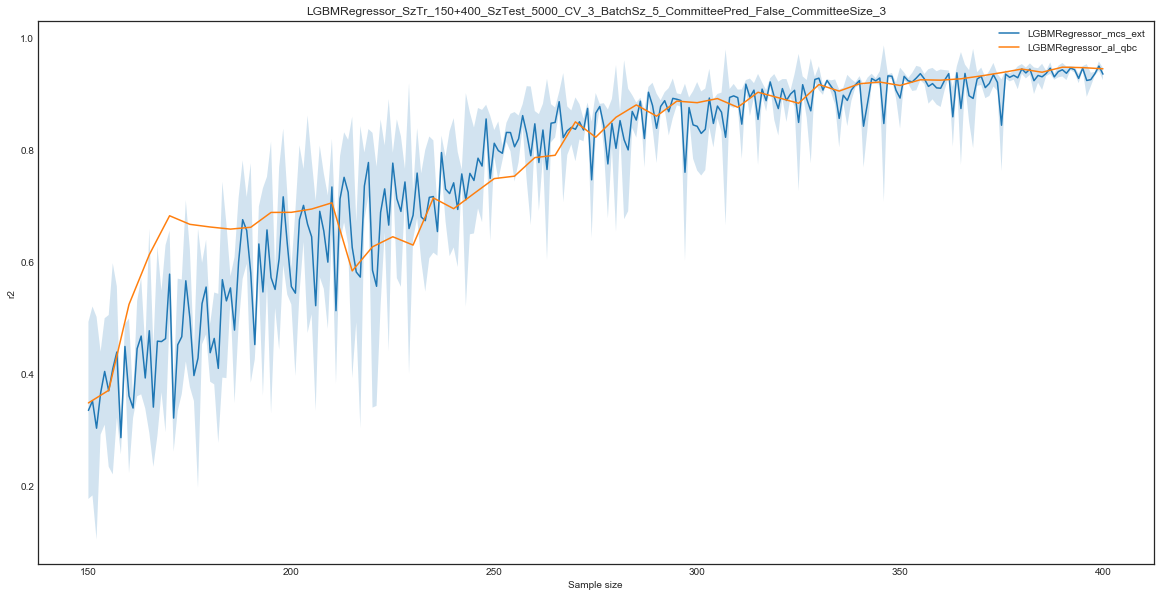

In [34]:
def plot_learning_curve_r2(df_target, label, title=''):
    df_target_filt = df_target[df_target.Model == mdl]
    df_target_mean = df_target_filt.groupby(['Model', 'Training_Size']).r2_val.mean().reset_index()
    df_target_std = df_target_filt.groupby(['Model', 'Training_Size']).r2_val.std().reset_index()
    plt.plot(df_target_mean.Training_Size, df_target_mean.r2_val, label=mdl + '_' + label, linestyle='-')
    plt.fill_between(df_target_mean.Training_Size, df_target_mean.r2_val - df_target_std.r2_val,
                     df_target_mean.r2_val + df_target_std.r2_val, alpha=0.2)
    ax.set_xlabel('Sample size')
    ax.set_ylabel('r2')
    ax.legend(loc='best')
    plt.title(title)
    return plt

metadata = pred_key + '_SzTr_' + str(seedSize) + '+' + str(size_train_set) + '_SzTest_' + str(
    size_test_set) + '_CV_' + str(cv_folds) + '_BatchSz_' + str(batchSize) + '_CommitteePred_' + str(
    committee_predictor) + '_CommitteeSize_' + str(numCommitteeMembers)

# res_df_qbc_filt = res_df_qbc[res_df_qbc['Training_Size'].isin(res_df_lhc.Training_Size.unique())]
# res_df_al_gpr_filt = res_df_al_gpr[res_df_al_gpr['Training_Size'].isin(res_df_lhc.Training_Size.unique())]

for mdl in res_df_random.Model.unique():
    with plt.style.context('seaborn-white'):
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111)
        plot_learning_curve_r2(res_df_random, 'mcs_ext', metadata)
        #plot_learning_curve_r2(res_df_lhc, 'lhc', metadata)
        plot_learning_curve_r2(res_df_qbc, 'al_qbc', metadata)
        #plot_learning_curve_r2(res_df_al_gpr, 'al_gpr', metadata)
        # fig.savefig('al_lhc_mcs_results' + mdl + '.png', dpi=300)
        plt.show()

In [10]:
for mdl in res_df_random.Model.unique():
    with plt.style.context('seaborn-white'):
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111)
        plot_learning_curve_r2(res_df_random, 'mcs_ext', metadata)
        #plot_learning_curve_r2(res_df_lhc, 'lhc', metadata)
        plot_learning_curve_r2(res_df_qbc, 'al_qbc', metadata)
        plot_learning_curve_r2(res_df_al_gpr, 'al_gpr', metadata)
        # fig.savefig('al_lhc_mcs_results' + mdl + '.png', dpi=300)
        plt.show()

NameError: name 'res_df_random' is not defined